In [57]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

## Part 1: Geometry of the feature space
The first crucial thing to internalize with all classification algorithms is that they make certain assumptions about how features are distributed and how features and classes are connected.

### Question 1
Go back through the lectures and answer the following questions:

What assumptions do the following methods make about the distribution of features for a certain class? What does this mean abstractly but also visually?

1. Linear discriminant analysis

For LDA we assume that the features for a certain class has an underlying gaussian distribution, and that the covariances are all the same.

2. Quadratic discriminant analysis

For QDA we assume that the features for a certain class has an underlying gaussian distribution.

3. kNN

For kNN we assume that the neighborhood of features are important, basically that classes exist in close proximity. $k$ decides how many neighbors are considered. A low $k$ means that the decision boundaries can become quite intricate, as they can encircle small clusters of a class that are close to a bigger cluster of another class.

4. CART

For CART we assume no distribution (misclassification is equally important for each class maybe?). Some 

Also think about the impact of $k$ in kNN and the impact of different parameters on the CART model

**Hint** Think about how each algorithm performs the classification. This tells you a lot about how features and classes are related. In more abstract terms (if that is your thing), think not just about a single 
$p(x|i)$ but also think about how these distributions are connected with the resulting classification rule $c(x)$. For example, nearest centroids classification assumes that $p(x|i) = N(x;μ_i,σ^2I)$ and then assigns classes using the decision rule

$$
c(x) = argmin_i||x-\mu_i||_2
$$

### Question 2

For the following questions focus on QDA and CART.

1) Simulate training and test data that follows the assumptions for each of the two models. (QDA, CART)

2) What are your expectations on the test error if you were to apply QDA to data simulated for CART and vice versa?

3) Train the methods on both training data sets and compare their respective test errors for each dataset. Were your expectations from Step 2 correct? Any surprises? Discuss!

4) Taking what you have learned from the project so far, can you simulate data for which the target method works best? (Clarifying example: Data simulated for QDA should be classified best by QDA and less well CART, and the other way around)

Note Make sure you repeat the simulation of the data many times. A result based on a single training and test dataset could be pure chance, especially due to the instability of CART. Write your code in such a fashion that you can easily create many training and test datasets repeat the comparison described above. Always report average values but always with a measure of uncertainty (e.g. standard deviation).

For most practical purposes you would not use a single CART model, but rather a bagged version or Random Forests. This exercise is meant to give you a feeling of the different capabilities of the two models.

**Answer:**
1) Data simulated below, data for QDA being gaussian, and for CART it is uniform.

2) Applying the "wrong" model to the data will give worse results, fitting a normal distribution to a uniform dataset will not yield optimal results. The same is true for the opposite case.

3) 

Loss = 0.020000000000000018


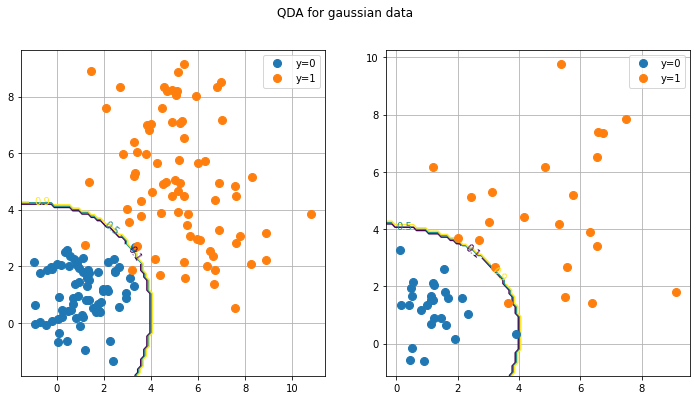

In [13]:
# 1) QDA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss


sz = (100,2)
x_gaus = np.random.normal(loc=[1,1], scale=[1,1], size=sz)
y_g = np.ones(200)
y_g[:100] = 0
x_gaus = np.append(x_gaus, np.random.normal(loc=[5,5], scale=[2,2], size=sz), axis=0)

x_g_train, x_g_test, y_g_train, y_g_test = train_test_split(x_gaus, y_g) 
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_g_train, y_g_train)

def plot_data(X_train, y_train, X_test, y_test, title = ''):
    # Plot the two data classes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axs[0].plot(X_train[y_train == 0][:,0], X_train[y_train == 0][:,1], 'o', markersize=8, label='y=0')
    axs[0].plot(X_train[y_train == 1][:,0], X_train[y_train == 1][:,1], 'o', markersize=8, label='y=1')

    axs[1].plot(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], 'o', markersize=8, label='y=0')
    axs[1].plot(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], 'o', markersize=8, label='y=1')

    for ax in axs:
        ax.legend()
        ax.grid()
    
    fig.suptitle(title)
    return fig, axs

def decision_boundary(model, fig, axs, levels = [0.1, 0.5, 0.9], labels = True):
    # Code for producing the plot
    for ax in axs:
        X1 = np.linspace(*ax.get_xlim(),100)
        X2 = np.linspace(*ax.get_ylim(), 100)
        Z = np.zeros(X1.shape+X2.shape)

        for i,x1 in enumerate(X1):
            for j,x2 in enumerate(X2):
                y_prob = model.predict(np.array([x1,x2]).reshape(1,-1))
                Z[j,i] = y_prob[0]
                
        contours = ax.contour(X1,X2,Z, levels=levels)
        if labels:
            ax.clabel(contours, inline=1, fontsize=10)
        
    return fig, axs


y_g_pred = qda.predict(x_g_test)
print(f'Loss = {zero_one_loss(y_g_test, y_g_pred)}')

fig, ax = plot_data(x_g_train, y_g_train, x_g_test, y_g_test, 'QDA for gaussian data')
fig, ax = decision_boundary(qda, fig, ax)

#fig2, ax2 = plot_data(x_g_test, y_g_test, 'QDA for gaussian testing data')
#fig2, ax2 = decision_boundary(qda, fig2, ax2)

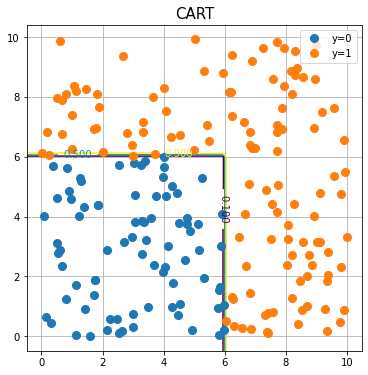

In [43]:
from sklearn.tree import DecisionTreeClassifier
# 1) CART
x_uni = np.random.uniform(low=0, high=10, size=(200,2))
y_uni = np.any(x_uni>6, axis=1)

cart = DecisionTreeClassifier()
cart.fit(x_uni, y_uni)

fig, ax = plot_data(x_uni, y_uni, 'CART')
fig, ax = decision_boundary(cart, fig, ax)

## Part 2: Actual data and classification metrics
For this question we will work with the UCI breast cancer dataset.

In [4]:
import pandas as pd

# Load UCI breast cancer dataset with column names and remove ID column
uci_bc_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", 
    sep=",",
    header=None,
    names=[
        "id_number", "diagnosis", "radius_mean",
        "texture_mean", "perimeter_mean", "area_mean",
        "smoothness_mean", "compactness_mean",
        "concavity_mean","concave_points_mean",
        "symmetry_mean", "fractal_dimension_mean",
        "radius_se", "texture_se", "perimeter_se",
        "area_se", "smoothness_se", "compactness_se",
        "concavity_se", "concave_points_se",
        "symmetry_se", "fractal_dimension_se",
        "radius_worst", "texture_worst",
        "perimeter_worst", "area_worst",
        "smoothness_worst", "compactness_worst",
        "concavity_worst", "concave_points_worst",
        "symmetry_worst", "fractal_dimension_worst"
    ],).drop("id_number", axis=1)

y = uci_bc_data.diagnosis.map({"B": 0, "M": 1}).to_numpy()
X = uci_bc_data.drop("diagnosis", axis=1).to_numpy()

When starting to investigate a classification dataset, there should be two basic steps you always (and especially now) take.

1. Investigate if the class labels are balanced or imbalanced.
2. Investigate the features

    a) Are they numerical or categorical?
    
    b) Do they have highly varying scales? Should data be scaled/normalized/centred before being used in a classification method? (More on this in lecture 5)
    
    c) How does the correlation matrix between the features look like? Are there highly correlated features? Are there plausible reasons for the correlations?

In [50]:
# Investigate if the class labels are balanced or imbalanced
print(sum(y)/len(y))

0.37258347978910367


So the class is slightly imbalanced, having more benign than malignant examples.

**a)** They are all numerical after we map the classification to 0 and 1 from 'B' and 'M'.

**b)** They do seem to have quite highly varying scales, things like the area has thousands of times larger values than some other. Or if you mean the standard error, that is true for some features as well.

**c)** Some of the features are very highly correlated. Things like mean area, perimeter, and radius should reasonably be highly correlated in the data as they are different measures of the size of tumors. This shows in the correlation matrix, with these covariances being near 1. 

In [58]:
print(uci_bc_data[['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se']])
print(uci_bc_data.corr())

     radius_se  texture_se  perimeter_se  area_se  smoothness_se  \
0       1.0950      0.9053         8.589   153.40       0.006399   
1       0.5435      0.7339         3.398    74.08       0.005225   
2       0.7456      0.7869         4.585    94.03       0.006150   
3       0.4956      1.1560         3.445    27.23       0.009110   
4       0.7572      0.7813         5.438    94.44       0.011490   
..         ...         ...           ...      ...            ...   
564     1.1760      1.2560         7.673   158.70       0.010300   
565     0.7655      2.4630         5.203    99.04       0.005769   
566     0.4564      1.0750         3.425    48.55       0.005903   
567     0.7260      1.5950         5.772    86.22       0.006522   
568     0.3857      1.4280         2.548    19.15       0.007189   

     compactness_se  concavity_se  concave_points_se  symmetry_se  \
0           0.04904       0.05373            0.01587      0.03003   
1           0.01308       0.01860            

In [57]:
print(uci_bc_data)

    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           M        17.99         10.38          122.80     1001.0   
1           M        20.57         17.77          132.90     1326.0   
2           M        19.69         21.25          130.00     1203.0   
3           M        11.42         20.38           77.58      386.1   
4           M        20.29         14.34          135.10     1297.0   
..        ...          ...           ...             ...        ...   
564         M        21.56         22.39          142.00     1479.0   
565         M        20.13         28.25          131.20     1261.0   
566         M        16.60         28.08          108.30      858.1   
567         M        20.60         29.33          140.10     1265.0   
568         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0            0.11840           0.27760         0.30010              

### Question 3

As mentioned above, it is more important for us to discover malignant tumours.

1. Choose a classification methods (classifier) and test the effect of different classification metrics (such as accuracy, specificity, the F1 score, etc.). What I mean by this is the following
    - Split your data into a bunch of folds (do this without stratification for now)
    - For each fold F
        - Train a model on the remaining training folds using the models standard mode of training (e.g. optimisation of a likelihood in the case of QDA, splitting on the Gini score in CART or Random Forest)
        - Compute classification metrics on the test fold F

    - Report the average performance across folds
2. Which classification metric(s?) is/are most suitable for our goal here? Explain why!
3. Choose one additional classification method that is substantially different (i.e. QDA and Random Forest, or logistic regression and CART. Not QDA and LDA, or logistic regression and LDA, they are too similar in their assumptions) and compare the two methods using the best classification metric(s) you determined in Step 2.
4. Does using stratified cross-validation change/improve your results?

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
kf.get_n_splits(X_train)

10

In [58]:
qda = QuadraticDiscriminantAnalysis()
rfc = RandomForestClassifier(max_depth=2, random_state=0)

In [61]:
def get_preds(pred_y, true_y):
    TP, FP, TN, FN = 0, 0, 0, 0
    for pred_y, true_y in zip(pred_y, true_y):
        if pred_y == 1 and true_y == 1:
            TP += 1
        elif pred_y == 1 and true_y == 0:
            FP += 1
        elif pred_y == 0 and true_y == 0:
            TN += 1
        else:
            FN += 1
    
    return TP, FP, TN, FN

for train_index, val_index in kf.split(X_train):
    F_X_train = [X_train[idx] for idx in train_index]
    F_y_train = [y_train[idx] for idx in train_index]
    qda.fit(F_X_train, F_y_train)
    rfc.fit(F_X_train, F_y_train)

    F_X_test = [X_train[idx] for idx in val_index]
    F_y_test = [y_train[idx] for idx in val_index]

    qda_acc = qda.score(F_X_test, F_y_test)
    rfc_acc = rfc.score(F_X_test, F_y_test)
    print(f'Accuracy QDA: {qda_acc}, Accuracy RFC: {rfc_acc}')

    qda_preds = qda.predict(F_X_test)
    rfc_preds = rfc.predict(F_X_test)

    qda_TP, qda_FP, qda_TN, qda_FN = get_preds(qda_preds, F_y_test)
    rfc_TP, rfc_FP, rfc_TN, rfc_FN = get_preds(rfc_preds, F_y_test)

    qda_F1 = qda_TP / (qda_TP + 0.5*(qda_FP+qda_FN))
    rfc_F1 = rfc_TP / (rfc_TP + 0.5*(rfc_FP+rfc_FN))
    print(f'F1 QDA: {qda_F1}, F1 RFC: {rfc_F1}')

    qda_precision = qda_TP / (qda_TP + qda_FP)
    rfc_precision = rfc_TP / (rfc_TP + rfc_FP)
    print(f'Precision QDA: {qda_precision}, Precision RFC: {rfc_precision}')

    qda_recall = qda_TP / (qda_TP + qda_FN) # Also called sensetivity
    rfc_recall = rfc_TP / (rfc_TP + rfc_FN)
    print(f'Recall QDA: {qda_recall}, Recall RFC {rfc_recall}')

    qda_specificity = qda_TN / (qda_TN + qda_FP)
    rfc_specificity = rfc_TN / (rfc_TN + rfc_FP)
    print(f'Specificity QDA: {qda_specificity}, Specificity RFC: {rfc_specificity}')

Accuracy QDA: 0.9347826086956522, Accuracy RFC: 0.9347826086956522
F1 QDA: 0.918918918918919, F1 RFC: 0.9090909090909091
Precision QDA: 0.8947368421052632, Precision RFC: 1.0
Recall QDA: 0.9444444444444444, Recall RFC 0.8333333333333334
Specificity QDA: 0.9285714285714286, Specificity RFC: 1.0
Accuracy QDA: 0.9782608695652174, Accuracy RFC: 0.9782608695652174
F1 QDA: 0.9767441860465116, F1 RFC: 0.9777777777777777
Precision QDA: 1.0, Precision RFC: 0.9565217391304348
Recall QDA: 0.9545454545454546, Recall RFC 1.0
Specificity QDA: 1.0, Specificity RFC: 0.9583333333333334
Accuracy QDA: 0.9782608695652174, Accuracy RFC: 0.9130434782608695
F1 QDA: 0.9696969696969697, F1 RFC: 0.875
Precision QDA: 1.0, Precision RFC: 0.9333333333333333
Recall QDA: 0.9411764705882353, Recall RFC 0.8235294117647058
Specificity QDA: 1.0, Specificity RFC: 0.9655172413793104
Accuracy QDA: 0.9565217391304348, Accuracy RFC: 0.9565217391304348
F1 QDA: 0.9444444444444444, F1 RFC: 0.9411764705882353
Precision QDA: 0.94